In [1]:
import healpy as hp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
from astropy.tests.helper import assert_quantity_allclose
import pickle
import sys
import os
from astropy import units as u

In [2]:
import h5py
s4 = h5py.File("cmbs4_tophat.h5", mode="r")

In [3]:
dataset = "s4_reference_design_noise_atmo_7splits"

In [4]:
ch = f"SAT-HFS1_chile"
nsplits = 1

In [5]:
# Parameters
ch = "SAT-MFLS1_chile"
nsplits = 7


In [6]:
if os.path.exists(f"plots/C_ell_{dataset}_{ch}_{nsplits}.png"):
    sys.exit(0)

In [7]:
sampling_frequency = dict(SAT=100*u.Hz, LAT=400*u.Hz)

In [8]:
#telescope = "SAT"
#channel = "LFS1"
#site = "pole"

In [9]:
telescope = ch.split("-")[0]
channel, site= ch.split("-")[1].split("_")

In [10]:
local_path = Path("output")
project_path = Path("/global/project/projectdirs/cmbs4/dm/dstool/output/")

In [11]:
C_ell = pickle.load(open(local_path / dataset / f"C_ell_{telescope}_{nsplits}.pkl", "rb"))

In [12]:
telescope, channel, site

('SAT', 'MFLS1', 'chile')

In [13]:
C_ell.keys()

dict_keys(['SAT-HFS1_chile', 'SAT-HFS2_chile', 'SAT-LFS1_chile', 'SAT-LFS2_chile', 'SAT-MFHS1_chile', 'SAT-MFHS2_chile', 'SAT-MFLS1_chile', 'SAT-MFLS2_chile'])

In [14]:
nside = 4096 if telescope == "LAT" else 512

In [15]:
from s4_design_sim_tool.core import base_folder

In [16]:
from s4_design_sim_tool.cli import parse_config
if site == "chile" and telescope == "SAT":
    config = parse_config(f"{dataset}.toml", "chile_sat.toml")
else:
    config = parse_config(f"{dataset}.toml")

In [17]:
hitmap = hp.read_map(local_path / dataset / ch / f"cmbs4_hitmap_{ch}_nside{nside}_1_of_{nsplits}.fits")

/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


In [18]:
channel

'MFLS1'

In [19]:
from s4_design_sim_tool.noise import get_tube_years
tube_years = get_tube_years(config, site, channel)
tube_years

21

In [20]:
sampling_rate = hitmap.sum()
sampling_rate /= 365.25 * 24 * 3600
sampling_rate /= tube_years * config["experiment"]["observing_efficiency"]
sampling_rate /= s4[channel].attrs["detectors_per_tube"]
sampling_rate *= nsplits
sampling_rate

100.11248600166542

In [21]:
np.testing.assert_allclose(sampling_rate, sampling_frequency[telescope].value, rtol=1/100)

/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor

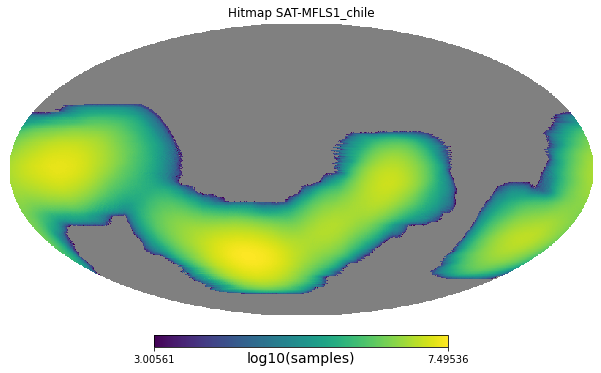

In [22]:
log_hitmap = np.log10(hitmap)
log_hitmap[np.isinf(log_hitmap)] = hp.UNSEEN
hp.mollview(log_hitmap, unit="log10(samples)", title=f"Hitmap {ch}")
plt.savefig(f"plots/hitmap_{channel}_{site}_1_of_{nsplits}.png")

In [23]:
wcov = hp.read_map(local_path / dataset / ch / f"cmbs4_wcov_{ch}_nside{nside}_1_of_{nsplits}.fits", (3))

In [24]:
wcov.shape

(3145728,)

In [25]:
import astropy.units as u

In [26]:
channel_NET = s4[channel].attrs["NET_uKsqrts"] * u.uK * u.s ** .5

In [27]:
if telescope == "LAT" and site=="pole":
    channel_NET = s4[channel].attrs["pole_NET_uKsqrts"] * u.uK * u.s ** .5

In [28]:
variance_QQ = wcov * u.K ** 2 * (hitmap / sampling_frequency[telescope]) 

In [29]:
assert (variance_QQ.value == hp.UNSEEN).sum() == 0

In [30]:
full_mission_NET = np.sqrt(np.median(variance_QQ[hitmap != 0]))

In [31]:
full_mission_NET.to(channel_NET.unit)

<Quantity 374.82874001 s(1/2) uK>

In [32]:
channel_NET

<Quantity 270. s(1/2) uK>

In [33]:
(full_mission_NET/np.sqrt(2)).to(channel_NET.unit)

<Quantity 265.04394384 s(1/2) uK>

In [34]:
assert_quantity_allclose(full_mission_NET, channel_NET*np.sqrt(2), rtol=10/100) 

In [35]:
sky_fraction = (hitmap > 0).sum() / len(hitmap)

In [36]:
sky_fraction

0.44712352752685547

In [37]:
pixarea = hp.nside2pixarea(nside)

In [38]:
np.mean(wcov[hitmap > 0])* pixarea

6.929399114114748e-16

In [39]:
wcov [ wcov == hp.UNSEEN] = 0

## Atmosphere

In [40]:
atmosphere_filename = Path(base_folder) / "00000000" / f"{site}_atmosphere_{telescope}_{channel}_filtered_telescope_all_time_all_bmap.fits"

In [41]:
input_atmophere = hp.ma(hp.read_map(atmosphere_filename, (0,1,2)))

/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/global/homes/z/zonca/condajupynersc/lib/python3.7/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")


In [42]:
sqrt_hitmap = hitmap.copy()
sqrt_hitmap[hitmap>0] = np.sqrt(hitmap[hitmap>0])

In [43]:
atmo_cl = \
hp.anafast(input_atmophere * sqrt_hitmap, use_pixel_weights=True) / np.mean(hitmap) # / sky_fraction

In [44]:
from s4_design_sim_tool.atmosphere import get_telecope_years

In [45]:
telescope_years = get_telecope_years(config, site, channel)

In [46]:
telescope_years

7

In [47]:
from s4_design_sim_tool.core import simulations_observing_efficiency

In [48]:
simulations_observing_efficiency

{'pole': {'SAT': 0.3931149305555555, 'LAT': 0.321544537037037},
 'chile': {'SAT': 0.8656164351851852, 'LAT': 0.917306712962963}}

In [49]:
atmo_cl *= 10 / 365.25
atmo_cl *= simulations_observing_efficiency[site.lower()].get(telescope, 1) / config["experiment"]["observing_efficiency"]                                                                    
atmo_cl /= telescope_years

## Noise

In [50]:
noise_filename = Path(base_folder) / "00000000" / f"{site}_noise_{telescope}_{channel}_filtered_telescope_all_time_all_bmap.fits"

In [51]:
#input_noise = hp.ma(hp.read_map(noise_filename, (0,1,2)))

In [52]:
#noise_cl = hp.anafast(input_noise * sqrt_hitmap, use_pixel_weights=True) / np.mean(hitmap) / sky_fraction

In [53]:
del sqrt_hitmap

In [54]:
from s4_design_sim_tool.noise import get_thinfp
thinfp = get_thinfp(channel)

In [55]:
thinfp

4


In [56]:
#noise_cl *= 10 / 365.25
#noise_cl *= simulations_observing_efficiency[site.lower()].get(telescope, 1) / config["experiment"]["observing_efficiency"]                                                                    
#noise_cl /= tube_years
#noise_cl /= thinfp

In [57]:
white_noise_Cl = channel_NET**2 \
/ (hitmap.sum() / sampling_frequency[telescope] / (hitmap>0).sum()) * pixarea # / sky_fraction

In [58]:
white_noise_Cl.decompose()

<Quantity 6.07658671e-18 K2>

In [59]:
import seaborn as sns

In [60]:
sns.set_style("whitegrid")

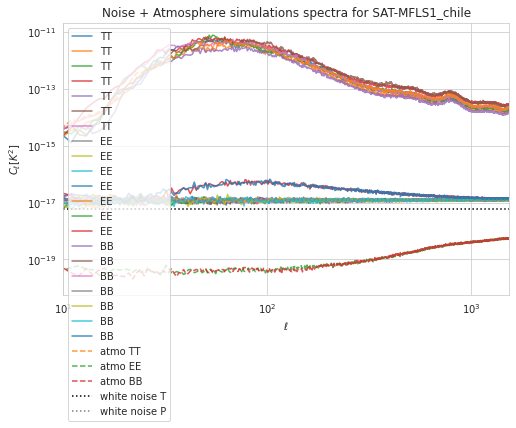

In [61]:
plt.figure(figsize=(8,5))

pols = ["TT", "EE", "BB"]

for i, pol in enumerate(pols):
    for split in range(1, nsplits+1):
        plt.loglog(C_ell[ch][split][i], alpha=.8, label=pol)

for i, pol in enumerate(pols):
    plt.loglog(atmo_cl[i]*nsplits, alpha=.8, ls="--", label=f"atmo {pol}")

#for i, pol in enumerate(pols):
#    plt.loglog(noise_cl[i], alpha=.8, ls="-.", label=f"noise {pol}")

plt.axhline(white_noise_Cl.to_value(u.K**2), ls=":",
           label="white noise T", color="black")
plt.axhline(white_noise_Cl.to_value(u.K**2)*2, ls=":",
           label="white noise P", color="grey")
plt.legend()
plt.title(f"Noise + Atmosphere simulations spectra for {ch}")
plt.ylabel("$C_\ell [K^2]$")
plt.xlabel("$\ell$")
plt.xlim((10, 3*nside))
plt.grid(True)
plt.savefig(f"plots/C_ell_{dataset}_{ch}_{nsplits}.png");